## Data cleaning file ##
In this document we will see how to download the data saved on the archiver of BESSY II, and how we have cleaned the data.


In [1]:
import datetime

import matplotlib
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
font = {'size'   : 12}
matplotlib.rc('font', **font)

import bact_archiver_bessyii            #needs to be specially downloaded, following 
archiver = bact_archiver_bessyii.BESSY  # https://github.com/hz-b/bact-archiver

import numpy as np
import pandas as pd
import seaborn
from tqdm import tqdm
import dateutil
import time
import os

# Example #
for downloading data. Notice that "PINH9FD5L:rdSigmaYav" is our y-value

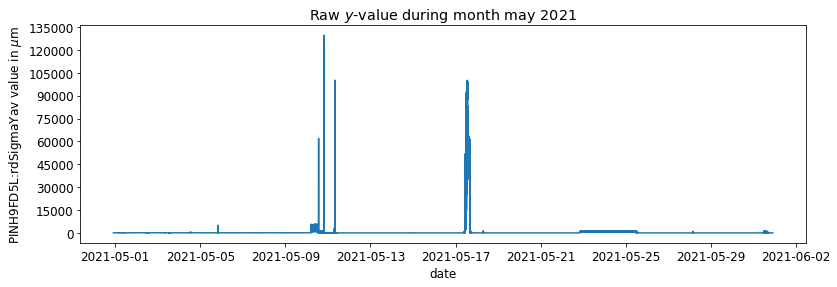

In [2]:
t0 = datetime.datetime(2021, 5, 1)    #give a start time point t0
t1 = datetime.datetime(2021, 6, 1)    #and an end time point t1

dataframe = archiver.getData("PINH9FD5L:rdSigmaYav", t0=t0, t1=t1, time_format='datetime') #This is the way, how 
plt.figure(figsize=(13,4))                                                                 #to download data 
plt.title("Raw $y$-value during month may 2021")
plt.xlabel("date")
plt.ylabel("PINH9FD5L:rdSigmaYav value in $\mu$m")
plt.plot(dataframe)
plt.gca().xaxis.set_major_locator(MaxNLocator(prune='lower'))   #avoid overlapping x and y labels
plt.gca().yaxis.set_major_locator(MaxNLocator(prune='lower'))


In [ ]:
def tool(dataframe,z0,z1,replace=False,x="val"):
    """
    Returns all (time-)indices which are between z0 and z1 
    """
    lst=np.where((dataframe.index>=z0)&(dataframe.index<=z1))[0] #find indices which lie in between z0 and z1
    if lst.shape[0]==0:       # in case lst is empty
        return dataframe      # return whole dataframe
    if lst[-1]==len(dataframe)-1: 
        if len(dataframe)==1:
            return pd.DataFrame({x:dataframe.iloc[lst[-1],0]},index=[z1])
        return dataframe.iloc[:lst[0]]
    
    a1=dataframe.iloc[:lst[0]]
    
    if replace==True:     #if replace is true, we want to append to a1 the last value the parameter attended during
        last_value= dataframe.iloc[lst[-1],0]               #the error time
        a1 = a1.append(pd.DataFrame({x:last_value},index=[z1]))
    return a1.append(dataframe.iloc[lst[-1]+1:])                   



#list of all error parameters
lst_errors=['OPMODECC:statLowBeam','OPMODECC:statDistOrbit','OPMODECC:statLowLifetime',
            'OPMODECC:statBeamBlowup','OPMODECC:statDistFill', 'OPMODECC:currShiftMode',
            'CQS2P2D2R:stat1','CQS2P2D2R:stat5','WFGENC1S10G:stOut','U125ID2R:CIOC:stat3',
            'U125ID2R:CIOC:stat1','U125ID2R:CIOC:stat0','U125ID2R:CIOC:stat4']



for r in tqdm(range(4,5)):              #give as list the months in the year 2021 the data should be generated
    t0=datetime.datetime(2021, r, 1)
    t1=datetime.datetime(2021, r+1, 1)
    
    #--------------------------
    # Dealing with error times 
    #--------------------------
    
    
    error_times=[]                  #list where we will add the indices with errors
    for x in lst_errors:
        
        temp=archiver.getData(x, t0=t0, t1=t1, time_format='datetime').rename(columns={"val":x}) #download parameter
                                                                                                 #        data       
        if x=='CQS2P2D2R:stat1' or x=='CQS2P2D2R:stat5' or x=='WFGENC1S10G:stOut':  #these error times are 1..
            temp[x]=1-temp[x]    #... if everything is alright, so change it, s.t. it fits to the other error times
        new_i=0
        for i in range(len(temp)):
            if int(temp.iloc[i])>0 and i>=new_i:             #if temp.iloc[i]>0 search for first j where it is 0
                for j in range(i,len(temp)):
                    if int(temp.iloc[j])==0:
                        error_times.append([temp.index[i],temp.index[j]])   #append the time to error_times
                        new_i=j                             #initialized such that we start looking only after j
                        break
                else:                            #if you can't find a j take t1 as border
                    error_times.append([temp.index[i],pd.Timestamp(t1,tz=dateutil.tz.tz.tzlocal())])

    '''
    Goal: Reduce length of error_times by combining error times which are close to each other/ subsets
    '''

    error_times=sorted(error_times, key=lambda x: x[0])      #sort each error time by first index
    error_times_new=[]
    new_i=0            #for later purposes
    
    for i in range(len(error_times)):
        if i>=new_i:
            for j in range(i+1,len(error_times)):         #find the first index j, s.t. the condition below is true
                if error_times[j][0]-error_times[i][1]>pd.Timedelta("10sec"):
                    error_times_new.append([error_times[i][0],max(error_times[k][1] for k in range(i,j))])
                                               #find the maximum end value, for all time indeces between i and j
                    new_i=j                    #start the next time at j
                    break
            else:
                error_times_new.append([error_times[i][0],error_times[i][1]])
                break
    error_times=error_times_new
    
    #--------------------------------------
    # Dealing with the BESSY II parameters
    #--------------------------------------
    
    #the following list shows the list of all parameters
    
    feature_list=["PINH9FD5L:rdSigmaYav",'PINH9FD5L:rdFwhmY',
              'WFGENC1S7G:rdVolt','WFGENC1S10G:rdVolt','WFGENC1S7G:setVolt',
              'TOPUPCC:rdCur','U125ID2R:CIOC:rdbk0','U139ID6R:CIOC:rdbk0',
              'U17IT6R:CIOC:rdbk0','U41IT3R:CIOC:rdbk0','U49ID4R:CIOC:rdbk0',
              'U49ID8R:CIOC:rdbk0','UE112ID7R:CIOC:rdbk0','UE112ID7R:CIOC:rdbk2',
              'UE46IT5R:CIOC:rdbk0','UE46IT5R:CIOC:rdbk2','UE48IT6R:CIOC:rdbk0',
              'UE49IT4R:CIOC:rdbk0','UE49IT4R:CIOC:rdbk2','UE49IT4R:CIOC:rdbk3',
              'UE56ID3R:CIOC:rdbk0','UE56ID3R:CIOC:rdbk1','UE56ID3R:CIOC:rdbk2',
              'UE56ID3R:CIOC:rdbk3','UE56ID6R:CIOC:rdbk0','UE56ID6R:CIOC:rdbk2',
              'HS1PD1R:rdbkSet','HS1PD3R:rdbkSet','HS1PD4R:rdbkSet','HS1PD5R:rdbkSet',
              'HS1PD6R:rdbkSet','HS1PD7R:rdbkSet','HS1PD8R:rdbkSet','HS1PT1R:rdbkSet',
              'HS1PT3R:rdbkSet','HS1PT4R:rdbkSet','HS1PT5R:rdbkSet','HS1PT6R:rdbkSet',
              'HS1PT7R:rdbkSet','HS1PT8R:rdbkSet','HS4P1D1R:rdbkSet','HS4P1D3R:rdbkSet',
              'HS4P1D4R:rdbkSet','HS4P1D5R:rdbkSet','HS4P1D6R:rdbkSet','HS4P1D7R:rdbkSet',
              'HS4P1D8R:rdbkSet','HS4P1T1R:rdbkSet','HS4P1T3R:rdbkSet','HS4P1T4R:rdbkSet',
              'HS4P1T5R:rdbkSet','HS4P1T6R:rdbkSet','HS4P1T7R:rdbkSet','HS4P1T8R:rdbkSet',
              'HS4P2D1R:rdbkSet','HS4P2D3R:rdbkSet','HS4P2D4R:rdbkSet','HS4P2D5R:rdbkSet',
              'HS4P2D6R:rdbkSet','HS4P2D7R:rdbkSet','HS4P2D8R:rdbkSet','HS4P2T1R:rdbkSet',
              'HS4P2T3R:rdbkSet','HS4P2T4R:rdbkSet','HS4P2T5R:rdbkSet','HS4P2T6R:rdbkSet',
              'HS4P2T7R:rdbkSet','HS4P2T8R:rdbkSet','VS2P1D1R:rdbkSet','VS2P1D3R:rdbkSet',
              'VS2P1D4R:rdbkSet','VS2P1D5R:rdbkSet','VS2P1D6R:rdbkSet','VS2P1D7R:rdbkSet',
              'VS2P1D8R:rdbkSet','VS2P1T1R:rdbkSet','VS2P1T3R:rdbkSet','VS2P1T4R:rdbkSet',
              'VS2P1T5R:rdbkSet','VS2P1T6R:rdbkSet','VS2P1T7R:rdbkSet','VS2P1T8R:rdbkSet',
              'VS2P2D1R:rdbkSet','VS2P2D3R:rdbkSet','VS2P2D4R:rdbkSet','VS2P2D5R:rdbkSet',
              'VS2P2D6R:rdbkSet','VS2P2D7R:rdbkSet','VS2P2D8R:rdbkSet','VS2P2T1R:rdbkSet',
              'VS2P2T3R:rdbkSet','VS2P2T4R:rdbkSet','VS2P2T5R:rdbkSet','VS2P2T6R:rdbkSet',
              'VS2P2T7R:rdbkSet','VS2P2T8R:rdbkSet','VS3P1D1R:rdbkSet','VS3P1D3R:rdbkSet',
              'VS3P1D4R:rdbkSet','VS3P1D5R:rdbkSet','VS3P1D6R:rdbkSet','VS3P1D7R:rdbkSet',
              'VS3P1D8R:rdbkSet','VS3P1T1R:rdbkSet','VS3P1T3R:rdbkSet','VS3P1T4R:rdbkSet',
              'VS3P1T5R:rdbkSet','VS3P1T6R:rdbkSet','VS3P1T7R:rdbkSet','VS3P1T8R:rdbkSet',
              'VS3P2D1R:rdbkSet','VS3P2D3R:rdbkSet','VS3P2D4R:rdbkSet','VS3P2D5R:rdbkSet',
              'VS3P2D6R:rdbkSet','VS3P2D7R:rdbkSet','VS3P2D8R:rdbkSet','VS3P2T1R:rdbkSet',
              'VS3P2T3R:rdbkSet','VS3P2T4R:rdbkSet','VS3P2T5R:rdbkSet','VS3P2T6R:rdbkSet',
              'VS3P2T7R:rdbkSet','VS3P2T8R:rdbkSet','FSBUMPCR:calcSpeed','FSBUMPCR:setAng',
              'FSBUMPCR:setDestAng','CQS2P1D3R:rdbkSet','CQS2P2D6R:rdbkSet',
              'CQS2P2T5R:rdbkSet','CQS3P1D6R:rdbkSet','CQS3P1T1R:rdbkSet',
              'CQS3P1T3R:rdbkSet','CQS3P1T7R:rdbkSet','CQS3P2D5R:rdbkSet',
              'CQS3P2D6R:rdbkSet','CQS3P2T1R:rdbkSet','CQS3P2T3R:rdbkSet',
              'CQS3P2T4R:rdbkSet','CQS3P2T6R:rdbkSet','CQS3P2T7R:rdbkSet',
              'W7IT1R:CIOC:rdbk0','W7IT2R:CIOC:rdbk0','UE52ID5R:CIOC:rdbk0',
              'W7IT7R:CIOC:rdbk0','UE52ID5R:CIOC:rdbk3','UE46IT5R:CIOC:rdbk3',
              'UE48IT6R:CIOC:rdbk3','UE112ID7R:CIOC:rdbk3','UE52ID5R:CIOC:rdbk2',
              'UE48IT6R:CIOC:rdbk2','CQS2P2D2R:rdbk']

    x=feature_list.pop(0)   #The first parameter PINH9FD5L:rdSigmaYav, is our y-value
    
    df = archiver.getData(x, t0=t0, t1=t1, time_format='datetime').rename(columns={"val":x})
    for z in error_times:            #drop error times
        df=tool(df,z[0],z[1])
    df.index=df.index.ceil('10ns')   #round the time points
    super_x=[]   #will become the list of all dataframes for all parameters

    super_x_idx=[]   #containing the names of the parameters, in the correct order
    
    for x in tqdm(feature_list):
        
        try:
            temp=archiver.getData(x, t0=t0, t1=t1, time_format='datetime').rename(columns={"val":x})
            for z in error_times:                          #drop error times
                temp=tool(temp,z[0],z[1],replace=True,x=x)
            temp2=pd.concat([df,temp], axis=1)    #concatenate the dataframe containing the y-value with
                                                  #the dataframe containing x. 
            idx=np.where(~(np.isnan(temp2['PINH9FD5L:rdSigmaYav'])))  #find indices, where the y-value is not NaN
            temp2.fillna(inplace=True,method="ffill")             #constant interpolation
            temp2.fillna(inplace=True,method="bfill")
            super_x.append(temp2[x].iloc[idx])             #append to the list super_x, only the values, where
            super_x_idx.append(x)                          #the y- value was not NaN
        except:         #in case data download doesn't work
            print("FAIL: ",x)
    
    
    ##################        
    #Vacuum Parameter
    #(self generated)
    ##################
    
    vacuum_list=["GPN1-1VS7R:rdPress","GPN1-2VS6R:rdPress","GPN1-3VS7R:rdPress", #list contains vacuum parameters
             "GPN2-1VS8R:rdPress","GPN2-2VS4R:rdPress","GPN3-3VS7R:rdPress",     #at different spots
             "GPN2-4VS1R:rdPress","GPN3-1VS7R:rdPress", "GPNI4VS1R:rdPress"]

    tz0=t0
    means=[]
    maxs=[]
    times=[]
    while tz0<t1:
        times.append(pd.Timestamp(tz0,tz=dateutil.tz.tz.tzlocal()))
        tz1=pd.Timestamp(min(tz0+pd.Timedelta("1day"),t1),tz=dateutil.tz.tz.tzlocal())
        means.append(np.mean([np.mean(archiver.getData(x, t0=tz0, t1=tz1, time_format='datetime')*10**8) for x in vacuum_list]))
        maxs.append(np.max([np.max(archiver.getData(x, t0=tz0, t1=tz1, time_format='datetime')*10**8) for x in vacuum_list]))
        tz0+=pd.Timedelta("1day")
    df_means = pd.DataFrame(means, index=times, columns=["vac_mean"])    
    df_maxs = pd.DataFrame(maxs, index=times, columns=["vac_max"])
    
    for z in error_times:            #drop error times
        df_means=tool(df_means,z[0],z[1],replace="True",x="vac_mean")
        df_maxs=tool(df_maxs,z[0],z[1],replace="True",x="vac_max")
    for temp,x in [[df_means,"vac_mean"],[df_maxs,"vac_max"]]: 
        temp2=pd.concat([df,temp], axis=1)
        idx=np.where(~(np.isnan(temp2['PINH9FD5L:rdSigmaYav'])))
        temp2.fillna(inplace=True,method="ffill")
        temp2.fillna(inplace=True,method="bfill")
        super_x.append(temp2[x].iloc[idx])
        super_x_idx.append(x)

    ##################
    #Finishing section
    ##################
    
    
    for i in range(len(super_x_idx)): #extend the dataframe df, with the new parameters
        df[super_x_idx[i]]=super_x[i].values.tolist()

    df.fillna(inplace=True,method="ffill")          #in theory unnecessary, just for safety reasons
    df.fillna(inplace=True,method="bfill")

    df = df[df["TOPUPCC:rdCur"]>280]                #last data cleaning procedure (if TOPUPCC:rdCur<280, BESSY II
                                                    #                              isn't fully functioning)
    df.to_pickle(f"Month_2021_number_{r}_to_{r+1}.pkl")    #save data set